# import packages

In [1]:
import pandas as pd
import numpy as np
import rmsp
import scipy.stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
rmsp.activate()

License cm5i9v6rd13d9al02dldit3kv checked out by cly4slc5f00khccb7fvfuloiy to cm3w8yybn03m0m7lwfaqtrkr3 expires in 60 minutes. A new version 1.17.2 of RMSP is available with new RBF kernel shapes, expanded polyline distance and offset tools, enhanced Drill Hole Optimizer summary tools, new open-pit mining constraints, and numerous fixes and performance improvements. See the release notes at https://portal.resourcemodelingsolutions.com/doc/releasenotes.html and https://portal.resourcemodelingsolutions.com/software to download the updated version. After upgrading this message may not update immediately.


# load and inspect data

In [3]:
# Loading data
df = pd.read_csv('example_data.csv')

# Converting Pandas Dataframe into a RMSP Point Data
df = rmsp.PointData(df, x='x', y="y", z="z")

In [4]:
df

,x,y,z,x1,tg
0,1.0,1.0,0.0,2.403560,1.199623
1,10.0,1.0,0.0,3.541236,NaN
2,20.0,1.0,0.0,2.452675,NaN
3,30.0,1.0,0.0,5.053473,4.298008
4,40.0,1.0,0.0,4.753003,4.612557
...,...,...,...,...,...
832,220.0,300.0,0.0,4.387805,4.187833
833,230.0,300.0,0.0,3.621725,3.686127
834,240.0,300.0,0.0,3.831457,NaN
835,250.0,300.0,0.0,3.841273,3.759928


In [5]:
df.describe()

,x,y,z,x1,tg
count,837.000000,837.000000,837.0,837.000000,418.000000
mean,130.037037,150.032258,0.0,4.956875,3.938228
std,77.873731,89.442225,0.0,1.002939,0.612753
min,1.000000,1.000000,0.0,2.403560,1.153421
25%,60.000000,70.000000,0.0,4.289736,3.707951
50%,130.000000,150.000000,0.0,4.980248,4.146265
75%,200.000000,230.000000,0.0,5.628691,4.332185
max,260.000000,300.000000,0.0,7.575391,4.770095


# eda

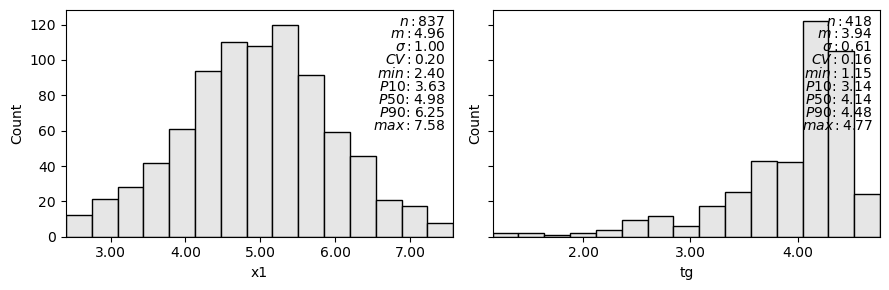

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the variables and plot the probability plots
for var, ax in zip(['x1', 'tg'], axes):
    df.histplot(var, ax=ax, num_bin=15)

# Adjust layout to prevent overlap
fig.tight_layout()

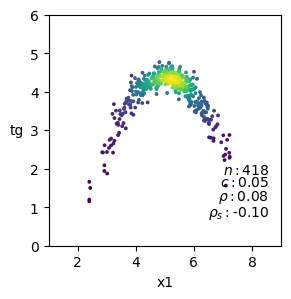

In [7]:
# Create the scatter plot matrix
fig = df.scatplots(['tg', 'x1'], s=3, figsize=(3, 3), num_sample=5000, stats='all')

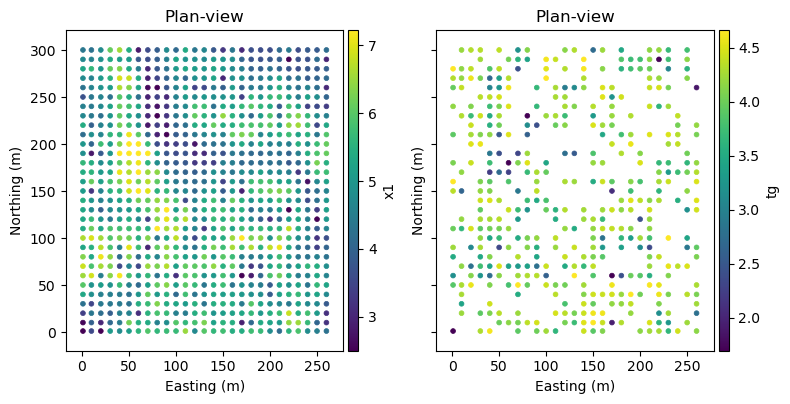

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
for var, ax in zip(['x1', 'tg'], axes):
    df.sectionplot(var, ax=ax, s=12, orient='xy')
fig.tight_layout()

In [9]:
# Function to compute empirical CDF
def empirical_cdf(data):
    sorted_data = np.sort(data)  # Sort the data
    cdf = np.linspace(1/len(sorted_data), 1, len(sorted_data))  # Generate CDF values
    return sorted_data, cdf

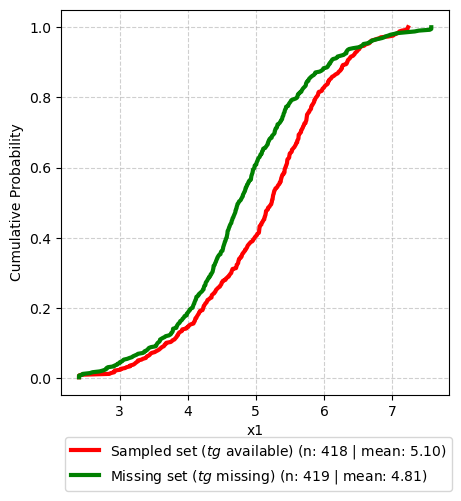

In [10]:
# Compute CDFs
x_complete, cdf_complete = empirical_cdf(df['x1'][df['tg'].notna()])
x_missing, cdf_missing = empirical_cdf(df['x1'][df['tg'].isna()])

# Plot CDFs
plt.figure(figsize=(5, 5))
plt.plot(x_complete, cdf_complete, label=f'Sampled set ($tg$ available) (n: {len(x_complete)} | mean: {x_complete.mean():.2f})', linewidth=3, color='red')
plt.plot(x_missing, cdf_missing, label=f'Missing set ($tg$ missing) (n: {len(x_missing)} | mean: {x_missing.mean():.2f})', linewidth=3, color='green')

# Add labels, title, legend, and grid
plt.legend(loc=(0.01,-0.25))
plt.xlabel('x1')
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

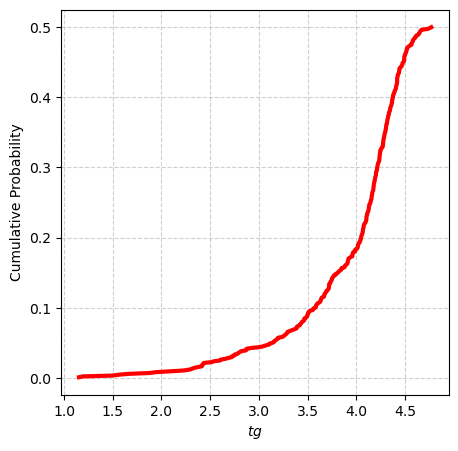

In [11]:
# Compute CDFs
y_dist, cdf_y = empirical_cdf(df['tg'])

# Plot CDFs
plt.figure(figsize=(5, 5))
plt.plot(y_dist, cdf_y, linewidth=3, color='red')

# Add labels, title, legend, and grid
plt.xlabel('$tg$')
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

# preprocess data

In [12]:
# initial definitions
variables = ['x1', 'tg']
var_x = ['x1'] # list containing all predictor variables
var_y = 'tg' # define name of the target variable as a str

## separate subsets

In [13]:
# separate homotopic (complete) portion from missing subset
df_complete = df.dropna()

In [14]:
# Defining validation and modeling subsets
df_valid = df_complete.sample(frac=0.15, random_state=42)
df_model = df_complete.drop(df_valid.index)

## despike
* Despiking is necessary to avoid distortions in the nscore transformation function due to spikes in the univariate distributions.

In [15]:
# Instantiate despiker object from rmsp
despiker = rmsp.DespikeMVSpatial()

# apply despiker to both variables in the modeling subset
df_model_dspk = despiker.fit_transform(df_model, variables)

# some post-processing
df_model_dspk.rename(columns=lambda x: x.replace("SP_DSPK_", ""), inplace=True) # suppressing default prefix from rmsp
df_model[variables] = df_model_dspk[variables] # Replacing columns in the modeling subset's dataframe

## normal score transformation

### fit and transform modeling subset
* Only the modeling set is considered for fitting, thus avoiding data leakage.

In [16]:
# instantiate transformer objects
nscorer_x1 = rmsp.NSTransformer(warn_no_wt=False)
nscorer_tg = rmsp.NSTransformer(warn_no_wt=False)

In [17]:
# fit transformers
nscorer_x1.fit(df_model[var_x].values[:,0])
nscorer_tg.fit(df_model[var_y].values)

In [18]:
# transform modeling set
var_x_ns_arr_mod = nscorer_x1.transform(df_model[var_x].values[:,0])
var_y_ns_arr_mod = nscorer_tg.transform(df_model[var_y].values)

### transform validation subset
* Based on the transformer fitted with the modeling subset. This avoids data leakage, presearving the integrity of the workflow.

In [19]:
# transform modeling set
var_x_ns_arr_valid = nscorer_x1.transform(df_valid[var_x].values[:,0])
var_y_ns_arr_valid = nscorer_tg.transform(df_valid[var_y].values)

# hyperparameter tuning
* Here, the GridSearch_KF class is used. 
* There is a normal score transformation step embeded in the k-folding iteration process. 
* To maintain the integrity of the cross-validation process and prevent information leakage between subsets, both the normal score transformation and model fitting are performed exclusively on the training portion of each fold within each iteration. The same transformation parameters (transformation lookup tables) and fitted model are then applied to the corresponding test subset. This ensures that the test data remains truly "unseen" during both transformation and model training, avoiding optimistic bias and preserving the model’s generalizability.
* In this example we stick with Stochastic Gradient Boosting, but the user can also test other ML algorithms. 

In [20]:
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import r2_score, mean_squared_error
import rmsp
import itertools
import random
import time
from sklearn.model_selection import KFold

class GridSearch_KF:

    def __init__(self, estimator, param_grid, n_folds, random_state):
        """
        Initialize the class.

        Parameters:
        - estimator: obj
            An object of that type is instantiated for each iteration. It is the base model for hyperparameter tunning.
        - param_grid: dict
            Dictionary with parameters names (str) as keys and distributions or lists of parameters to try.
        - n_folds: int
            Number of non-overlapping splits to be performed on the k-fold cross-validation framework.
        - random_state: int
            Seed for reproducibility in splitting the data into training and test.

        """
        self.base_model = estimator
        self.param_grid = param_grid
        self.n_folds = n_folds
        self.random_state = random_state
        self.results_dict = {}
        self.best_r2_test = -float('inf') # Initialize worst R² as very low
        self.best_r2_train = -float('inf') # Initialize worst R² as very low
        self.best_params = None
        self.worst_r2_test = float('inf')  # Initialize worst R² as very high
        self.worst_r2_train = float('inf')  # Initialize worst R² as very high
        self.worst_params = None
        self.refitted_model = None  # Stores the final model trained on all data

    def fit(self, data, var_x, var_y):
        """
        Run k-fold cross-validation for multiple scenarios and store results.

        Parameters:
        - data: pandas.DataFrame
            Dataset containing input features and target variable in original units.
        - var_x: list[str]
            List of input feature column names.
        - var_y: str
            Name of the (single) target variable in the dataframe.

        Returns:
        - results_dict: dict
            Dictionary containing results for all iterations.
        """

        var_full = var_x + [var_y]

        # Generate all combinations for tuning parameters (excluding fixed ones)
        param_combinations = list(itertools.product(*self.param_grid.values()))
        print(f'Initializing... there are {len(param_combinations)} possible combinations of hyperparameters')
        print(f'Running all {len(param_combinations)} combinations...\n')
        
        # Initialize timer
        start_time = time.time()
                  
        # Iterate through the shuffled combinations
        for index, combination in enumerate(param_combinations):
            
            # Initialize timer for iteration
            iter_start_time = time.time()
            
            # Create a dictionary for the current hyperparameter configuration
            param_config = dict(zip(self.param_grid.keys(), combination))
        
            # Merge fixed parameters from base_model with current param_config
            full_params = {**self.base_model.get_params(), **param_config}
        
            # Instantiating model object correctly with fixed + dynamic parameters
            model = type(self.base_model)(**full_params)
    
            # Initialize K-Fold object
            kf = KFold(self.n_folds, shuffle=True, random_state=self.random_state)
            
            # Initialize arrays to store metrics for the run with the selected combination of hyperparameters
            r2_comb_test, rmse_comb_test = np.array([]), np.array([])
            r2_comb_train, rmse_comb_train = np.array([]), np.array([])
        
            # Loop over k non-overlapping splits
            for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data)):
    
               # Split data into training and test sets using indices
                train_data = data.iloc[train_idx]
                test_data = data.iloc[test_idx]
        
                # Add prefixes "NS_" and "SP_DSPK_" to each variable to be compatible after transformation
                var_x_ns = ['NS_' + i for i in var_x]
                var_y_ns = f'NS_{var_y}'

                # NS fit_transform for multiple variables
                nstransformer_mv = rmsp.NSTransformerMV(warn_no_wt=False)
                train_prepared = nstransformer_mv.fit_transform(train_data[var_full])
                X_train, y_train = train_prepared[var_x_ns].values, train_prepared[var_y_ns].values
        
                # Transform test data, applying the parameters from the training set, thus avoiding data leakage
                test_prepared = nstransformer_mv.transform(test_data[var_full])
                X_test, y_test = test_prepared[var_x_ns].values, test_prepared[var_y_ns].values
        
                # Fit model with transformed training data
                model.fit(X_train, y_train)
        
                # Predict test and training data
                pred_test = model.predict(X_test)
                pred_train = model.predict(X_train)
        
                # Compute metrics inside the fold and append to the array relative to the iteration's
                r2_fold_test = r2_score(y_test, pred_test)
                r2_comb_test = np.append(r2_comb_test, r2_fold_test)       
                rmse_fold_test = np.sqrt(mean_squared_error(y_test, pred_test))
                rmse_comb_test = np.append(rmse_comb_test, rmse_fold_test)

                r2_fold_train = r2_score(y_train, pred_train)
                r2_comb_train = np.append(r2_comb_train, r2_fold_train)       
                rmse_fold_train = np.sqrt(mean_squared_error(y_train, pred_train))
                rmse_comb_train = np.append(rmse_comb_train, rmse_fold_train)
    
            # Calculate the average value for the run with the selected combination of hyperparameters
            r2_comb_test_avg = np.mean(r2_comb_test)
            rmse_comb_test_avg = np.mean(rmse_comb_test)
            r2_comb_train_avg = np.mean(r2_comb_train)
            rmse_comb_train_avg = np.mean(rmse_comb_train)
        
            # Finish timer for iteration with the selected combination of hyperparameters  
            iter_end_time = time.time()
            iter_elapsed_time = (iter_end_time - iter_start_time) / 60
        
            # Print status
            sys.stdout.write(f"\rIteration {index+1}/{len(param_combinations)} - Avg test R²: {r2_comb_test_avg:.4f} | Avg train R²: {r2_comb_train_avg:.4f} - Time: {iter_elapsed_time:.2f} min ")
            sys.stdout.flush()

            # Store results
            self.results_dict[index + 1] = {
                "r2_test": r2_comb_test_avg,
                "rmse_test": rmse_comb_test_avg,
                "r2_train": r2_comb_train_avg,
                "rmse_train": rmse_comb_train_avg,
                "params": full_params
            }

            # Check if this is the best R² so far
            if r2_comb_test_avg > self.best_r2_test:
                self.best_r2_test = r2_comb_test_avg
                self.best_r2_train = r2_comb_train_avg
                self.best_params = full_params  # Store best parameters

            # Check if this is the worst R² so far
            if r2_comb_test_avg < self.worst_r2_test:
                self.worst_r2_test = r2_comb_test_avg
                self.worst_r2_train = r2_comb_train_avg
                self.worst_params = full_params  # Store worst parameters
    
        # Sort and store the top 3 configurations
        sorted_results = sorted(self.results_dict.values(), key=lambda x: x["r2_test"], reverse=True)
        self.top_3_results = sorted_results[:3]  # Take top 3 configurations

        # Finish timer
        end_time = time.time()
        elapsed_time = (end_time - start_time) / 60
        print(f"\n\nTotal time for {len(param_combinations)} iterations: {elapsed_time:.2f} minutes")

    def get_top_3_params(self):
        """
        Retrieve the top 3 hyperparameter combinations based on R² score.

        Returns:
        - list[dict]: List of top 3 configurations.
        """
        if not self.top_3_results:
            print("No top results available. Run `fit()` first.")
            return None

        return self.top_3_results
       
    def print_best_params(self):
        """
        Retrieve the best hyperparameter combination found.

        Returns:
        - dict: Best hyperparameters and R² score.
        """
        if self.best_params is None:
            print("No model has been trained yet. Run `fit()` first.")
            return None

        # Print best hyperparameters
        print(f"\nBest test R² score: {self.best_r2_test:.4f}")
        print(f"Associated training R² score: {self.best_r2_train:.4f}")
        print("\nBest hyperparameter combination:")
        for key, value in self.best_params.items():
            print(f"  {key}: {value}")

    def print_best_score(self):
        """
        Retrieve the R2 obtained from the best hyperparameter combination found.

        Returns:
        - Best R² score.
        """
        if self.best_params is None:
            print("No model has been trained yet. Run `fit()` first.")
            return None

        # Print best hyperparameters
        print(f"\nBest test R² score: {self.best_r2_test:.4f}\n")
        print(f"Associated training R² score: {self.best_r2_train:.4f}")

    def print_worst_score(self):
        """
        Retrieve the R2 obtained from the worst hyperparameter combination found.

        Returns:
        - Worst R² score.
        """
        if self.worst_params is None:
            print("No model has been trained yet. Run `fit()` first.")
            return None

        # Print best hyperparameters
        print(f"\nWorst test R² score: {self.worst_r2_test:.4f}\n")
        print(f"Associated training R² score: {self.worst_r2_train:.4f}")

    def print_worst_params(self):
        """
        Retrieve the worst hyperparameter combination found.

        Returns:
        - dict: Worst hyperparameters and R² score.
        """
        if self.worst_params is None:
            print("No model has been trained yet. Run `fit()` first.")
            return None
        
        # Print worst hyperparameters
        print(f"\Worst R² score: {self.worst_r2:.4f}")
        print("Worst hyperparameter combination:")
        for key, value in self.worst_params.items():
            print(f"  {key}: {value}")

    def best_model(self):
        """
        Return a new instance of the model with the best hyperparameters.

        Returns:
        - obj: A new model instance with the best hyperparameters.
        """
        if self.best_params is None:
            print("No model has been trained yet. Run `fit()` first.")
            return None

        return type(self.base_model)(**self.best_params)

    def refit_best_model(self, data, var_x, var_y):
        """
        Refit the model with the best hyperparameters using all available data.

        Parameters:
        - data: pandas.DataFrame
            Full dataset for training.
        - var_x: list[str]
            List of input feature column names.
        - var_y: str
            Name of the (single) target variable in the dataframe.

        Returns:
        - obj: The final trained model.
        """

        var_full = var_x + [var_y]

        if self.best_params is None:
            print("No best model found. Run `fit()` first.")
            return None

        # Instantiate the model with best parameters
        self.refitted_model = type(self.base_model)(**self.best_params)

        # NS fit_transform for multiple variables
        nstransformer_mv = rmsp.NSTransformerMV(warn_no_wt=False)
        data_prepared = nstransformer_mv.fit_transform(data[var_full])

        # Extract transformed features and target
        var_x_ns = ['NS_' + i for i in var_x]
        var_y_ns = ['NS_' + var_y]
        X_train, y_train = data_prepared[var_x_ns].values, data_prepared[var_y_ns].values.flatten()

        # Train the final model
        self.refitted_model.fit(X_train, y_train)

        # Calculate R2 from the training data for reference
        pred = self.refitted_model.predict(X_train)
        r2_train = r2_score(y_train, pred)

        print("\nBest model has been refitted using all data.")
        print(f"R2 from training data (just for reference): {r2_train:.4f}")
        return self.refitted_model

In [21]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [3, 4],
    'subsample': [0.7, 0.8],
}

In [22]:
# instantiate base model
base_model = GradientBoostingRegressor(random_state=42)

# instantiate randomized search object
grid_search = GridSearch_KF(estimator=base_model, param_grid=param_grid, n_folds=10, random_state=42)

# instantiate workflow with the training data
grid_search.fit(df_model, var_x, var_y)

Initializing... there are 64 possible combinations of hyperparameters
Running all 64 combinations...

Iteration 64/64 - Avg test R²: 0.6814 | Avg train R²: 0.7902 - Time: 0.01 min 

Total time for 64 iterations: 0.45 minutes


## instantiate regressor object and predict values in the validation set

In [23]:
# Retrieve the best model and refit it on modeling set
model_ml = grid_search.refit_best_model(df_model, var_x, var_y)


Best model has been refitted using all data.
R2 from training data (just for reference): 0.7635


In [31]:
# predict
predicted_ns = model_ml.predict(var_x_ns_arr_valid.reshape(-1, 1))

In [32]:
# backtransform predicted values
predicted = nscorer_tg.inverse_transform(predicted_ns)

# validate regression model

In [45]:
# Evaluating model
ml_mse = mean_squared_error(df_valid[var_y].values, predicted)
ml_rmse = np.sqrt(ml_mse)
ml_r2 = r2_score(df_valid[var_y].values, predicted)

print('\nMetrics calculated on the validation subset')
print(f'RMSE: {np.round(ml_rmse, 4)}')
print(f'R2: {np.round(ml_r2, 4)}')


Metrics calculated on the validation subset
RMSE: 0.2748
R2: 0.8341


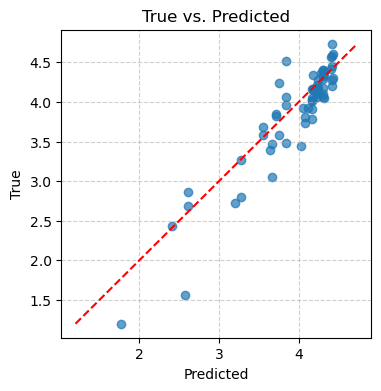

In [38]:
# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(predicted, df_valid['tg'], alpha=0.7)

# 1:1 Line
plt.plot([min(df_valid['tg']), max(df_valid['tg'])], [min(df_valid['tg']), max(df_valid['tg'])], color='red', linestyle='--')

# Labels & Title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("True vs. Predicted")
plt.grid(True, linestyle="--", alpha=0.6)

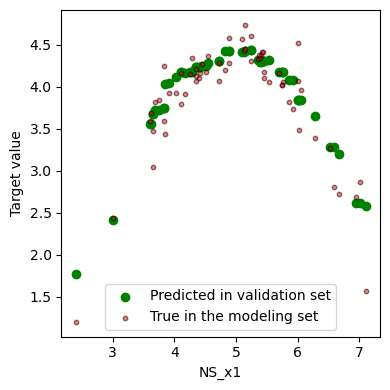

In [41]:
# Scatter plot for predicted values
plt.figure(figsize=(4, 4))
plt.scatter(df_valid[var_x], predicted, alpha=1, color='green', label='Predicted in validation set')

# Scatter plot for training data
plt.scatter(df_valid[var_x], df_valid[var_y], alpha=0.5, edgecolor='k', s=10, label='True in the modeling set', color='red')

# Add legend
plt.legend()

# Add axis labels (optional, but helpful)
plt.xlabel('NS_x1')
plt.ylabel('Target value')

# Adjust layout and display
plt.tight_layout()
plt.show()

# estimate R2 parameter
* The ranges of the r_squared values to be tested should be based on a k-fold cross validation step, to be run prior to this

In [46]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal, norm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import rmsp
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

class ConditionalML:
    """
    Initializes the ConditionalML class to apply a machine learning algorithm to predict values
    and assume a Gaussian distribution of variance '1 - r_squared' centered on the predicted value
    to construct a conditional distribution and calculate the quantiles.

    Parameters:
    - n_quantiles: int, number of quantiles to compute.
    """
    def __init__(self, regressor, n_quantiles=500, reg_hyperparams=None, r_squared=0):
        """
        Initialize the ConditionalML class with the provided parameters.
        
        Parameters:
        - regressor: The regression algorithm to be used for conditional distribution (LinearRegression, RandomForestRegressor, GradientBoostingRegressor, KNN or SVR).
        - n_quantiles (int): The number of quantiles to use for conditional distributions.
        - reg_hyperparams (dict): Hyperparameters specific to the chosen regressor.
        - r_squared (float): R-squared value for calculating the conditional variance 
        """
        self.n_quantiles = n_quantiles
        self.quantile_levels = np.round(np.linspace(0.001, 0.999, n_quantiles), 3)
        self.regressor = regressor(**(reg_hyperparams if reg_hyperparams is not None else {}))
        self.r_squared = r_squared

    def fit(self, X, y):
        """
        Train the model using the training data.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the input features.
        - y: numpy array, shape (n_samples,), the target variable.
        """

        # Remove rows with missing values for training
        mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
        X = X[mask]
        y = y[mask]

        # Fitting the model with the chosen algorithm
        self.regressor.fit(X, y)
      
    def predict(self, X, return_pdf=False):
        """
        Predict the conditional means, variances, quantiles, and optionally PDF values using the trained model.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the input features.
        - return_pdf: bool, if True, returns the PDF values.

        Returns:
        - conditional_means: numpy array, the conditional means.
        - conditional_variances: numpy array, the conditional variances.
        - conditional_quantiles: np.ndarray, array of conditional quantiles for each sample.
        - conditional_pdfs (optional): np.ndarray, array of PDF values for each sample (if return_pdf is True).
        - primary_ranges (optional): np.ndarray, array of reference values to calculate the PDF values for each sample (if return_pdf is True).
        """
        # Predict the means
        conditional_means = self.regressor.predict(X)
        
        # Calculate the conditional variance
        conditional_variances = np.ones(X.shape[0]) * (1.0 - self.r_squared)
        
        # Initialize arrays to store the quantiles and PDFs if needed
        conditional_quantiles = np.zeros((X.shape[0], self.n_quantiles))
        conditional_pdfs = [] if return_pdf else None
        primary_ranges = [] if return_pdf else None

        # Define a range of values for the primary variable to estimate the conditional density
        for idx, mean in enumerate(conditional_means):
            variance = conditional_variances[idx]
            primary_range = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), self.n_quantiles).reshape(-1, 1)
            pdf_values = (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-((primary_range - mean) ** 2) / (2 * variance))
            cdf_values = np.cumsum(pdf_values) / np.sum(pdf_values)
            
            for j, quant in enumerate(self.quantile_levels):
                quantile_value = primary_range[np.searchsorted(cdf_values, quant)][0]
                conditional_quantiles[idx, j] = quantile_value
            
            if return_pdf:
                conditional_pdfs.append(pdf_values.flatten())
                primary_ranges.append(primary_range.flatten())
        
        if return_pdf:
            return conditional_means, conditional_variances, conditional_quantiles, np.array(conditional_pdfs), np.array(primary_ranges)
        else:
            return conditional_means, conditional_variances, conditional_quantiles
    
    def get_quantile_levels(self):
        """
        Get the quantile levels that were used.

        Returns:
        - numpy array: The quantile levels.
        """
        return self.quantile_levels

In [54]:
class AccuracyEvaluator:
    def __init__(self, quantile_levels, quantile_values, true_values):
        self.quantile_levels = quantile_levels
        self.quantile_values = quantile_values
        self.true_values = true_values

        # Initialize a dictionary to store evaluation metrics
        self.results = {
            'Accuracy': [],
            'Accuracy_Alternative': [],
            'Precision': [],
            'Goodness': [],
            'Fitness': [],
        }
        self._results_calculated = False  # A flag to check if results have been calculated

    def get_proportions(self, num_intervals=20):
        n_samples, n_quantiles = self.quantile_values.shape
        true_quantile_levels = np.zeros(n_samples) # Initialize array that will store the quantile levels that correspond to the true values

        # Iterate over samples
        for i in range(n_samples):
            quantiles = self.quantile_values[i] # Get true value for ith sample  
            quantile_index = np.searchsorted(quantiles, self.true_values[i], side='right') - 1 # Get index of the closest quantile level (to the right)

            # Find quantile level that corresponds to the true quantile index (approximated)
            true_quantile_levels[i] = self.quantile_levels[quantile_index]

        self.proportions = {}
        self.probabilities = []
        interval_step = 100 // num_intervals
        for p in range(interval_step, 101, interval_step):
            lower_bound = (100 - p) / 200
            upper_bound = 1 - lower_bound
            within_interval = (true_quantile_levels >= lower_bound) & (true_quantile_levels <= upper_bound)
            proportion = np.mean(within_interval)
            self.proportions[f"{p}% symmetric interval"] = proportion
            self.probabilities.append(p)
        
        return self.proportions

    def _calculate_results(self, num_intervals=20):
        if not self._results_calculated:
            proportions = self.get_proportions(num_intervals=num_intervals)
            intervals = list(range(100 // num_intervals, 101, 100 // num_intervals))
            proportions = [proportions[f"{p}% symmetric interval"] for p in intervals]
            indicators, absolute_differences, goodness_term1_list, goodness_term2_list = [], [], [], []

            for prop, prob in zip(proportions, self.probabilities): #prop is the proportion of true values, prob is the associated probability interval
                prob = prob / 100
                indicator = int(prop >= prob)
                abs_diff = abs(prop - prob)
                goodness_term1 = indicator * abs_diff
                goodness_term2 = (1 - indicator) * abs_diff
                weighted_diff = abs_diff * indicator
                indicators.append(indicator)
                absolute_differences.append(weighted_diff)
                goodness_term1_list.append(goodness_term1)
                goodness_term2_list.append(goodness_term2)

            # Calculate accuracy
            accuracy = sum(indicators) / len(self.probabilities)
            accuracy_alternative = (1 - np.sum(goodness_term2_list) / np.count_nonzero(goodness_term2_list)) if np.count_nonzero(goodness_term2_list) != 0 else 1
            
            # Calculate precision
            if accuracy == 0:
                precision = np.nan
            else:
                precision = 1 - 2 * (sum(absolute_differences) / len(self.probabilities))

            # Calculate goodness
            goodness = 1 - ((sum(goodness_term1_list) / len(self.probabilities)) + (2 * (sum(goodness_term2_list) / len(self.probabilities))))

            # Calculate fitness level
            fitness = 1 - ((sum(goodness_term1_list) / len(self.probabilities)) + ((sum(goodness_term2_list) / len(self.probabilities))))

            # Consolidate results
            self.results['Accuracy'].append(accuracy)
            self.results['Accuracy_Alternative'].append(accuracy_alternative)
            self.results['Precision'].append(precision)
            self.results['Goodness'].append(goodness)
            self.results['Fitness'].append(fitness)

            self._results_calculated = True  # Set the flag to True after calculation

    def accuracy_plot(self, figsize=(5, 5), num_intervals=20, show_results=True, leg_loc='upper right', leg_visible=True):

        """
        Accuracy plot based on the count of true values within probability intervals.

        Parameters:
        - figsize: Size of the figure (default is (30, 20))
        - num_intervals: Number of probability intervals to consider
        - show_results: whether or not to show the metrics (accuracy, precision, goodness) 
        - leg_loc: location of the legend if num_samples=1 (default is 'upper right')
        - leg_visible: set if legend is to be shown or not (default is 'True')
        """
        self._calculate_results(num_intervals)
        
        plt.figure(figsize=figsize)
        plt.scatter(self.probabilities, list(self.proportions.values()), s=20, color='black', label='Prop. of True Values in Prob. Interval')
        plt.plot([0, 100], [0, 1], color='blue', linestyle='--', label='Reference Line')
        plt.xlabel('Probability interval', fontsize=12)
        plt.ylabel('Proportion of true values', fontsize=12)
        plt.grid(True, color='grey', linestyle='--', linewidth=0.2)
        if show_results:
            plt.text(0.70, 0.40, f'Count = {len(self.true_values)}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
            plt.text(0.70, 0.35, f'Accuracy = {self.results["Accuracy"][-1]:.3f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
            plt.text(0.70, 0.30, f'Accuracy(alt.) = {self.results["Accuracy_Alternative"][-1]:.3f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
            plt.text(0.70, 0.25, f'Precision = {self.results["Precision"][-1]:.3f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
            plt.text(0.70, 0.20, f'Goodness = {self.results["Goodness"][-1]:.3f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
            plt.text(0.70, 0.20, f'Fitness = {self.results["Fitness"][-1]:.3f}', transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='center')
        plt.legend(fontsize=10, loc=leg_loc).set_visible(leg_visible)
        plt.show()

    def get_results(self, num_intervals=20):
        self._calculate_results(num_intervals)
        return pd.DataFrame(self.results)

In [57]:
# Define quantile levels
n_quantiles = 500
quantile_levels = np.round(np.linspace(0.001, 0.999, n_quantiles), 3)

# Define the range for r_squared values based on 
r2_test_avg = 0.60
r2_train_avg = 0.7619
r2_kfolds_min = 0.5591
r2_kfolds_max = 0.80
r_squared_values = np.linspace(r2_kfolds_min, r2_kfolds_max, 12)

# Prepare arrays to store results
tested_r_squared = np.zeros(len(r_squared_values))
goodness_metrics = np.zeros(len(r_squared_values))

# Iterate over each r_squared value
for i, r_squared in enumerate(r_squared_values):
    # Create ml model instance
    model_ml = ConditionalML(
        regressor=GradientBoostingRegressor,
        r_squared=r_squared,
        reg_hyperparams={'alpha': 0.9,
                         'ccp_alpha': 0.0,
                         'criterion': 'friedman_mse',
                         'init': None,
                         'learning_rate': 0.05,
                         'loss': 'squared_error',
                         'max_depth': 2,
                         'max_features': None,
                         'max_leaf_nodes': None,
                         'min_impurity_decrease': 0.0,
                         'min_samples_leaf': 4,
                         'min_samples_split': 4,
                         'min_weight_fraction_leaf': 0.0,
                         'n_estimators': 100,
                         'n_iter_no_change': None,
                         'random_state': 42,
                         'subsample': 0.8,
                         'tol': 0.0001,
                         'validation_fraction': 0.1,
                         'verbose': 0,
                         'warm_start': False}
    )

    # train usin modeling data
    model_ml.fit(var_x_ns_arr_mod.reshape(-1,1), var_y_ns_arr_mod)

    # Predict on validation set
    _, _, quantiles_ml_ns, _, _ = model_ml.predict(var_x_ns_arr_valid.reshape(-1,1), return_pdf=True)

    # Inverse transform
    quantiles_ml = np.array([nscorer_tg.inverse_transform(quantile) for quantile in quantiles_ml_ns])

    # Evaluate accuracy
    acc_ml = AccuracyEvaluator(quantile_levels, quantiles_ml, df_valid[var_y].values)
    acc_ml_metrics = acc_ml.get_results()

    # Save r_squared and Goodness value
    tested_r_squared[i] = r_squared
    goodness_metrics[i] = acc_ml_metrics['Goodness']

In [58]:
# Find index of maximum Goodness
max_idx = np.argmax(goodness_metrics)

# Retrieve corresponding values
best_r_squared = tested_r_squared[max_idx]
best_goodness = goodness_metrics[max_idx]

# Print results
print(f"Highest Goodness: {best_goodness.round(4)}")
print(f"Optimum R2: {best_r_squared.round(4)}")

Highest Goodness: 0.9793
Optimum R2: 0.7562


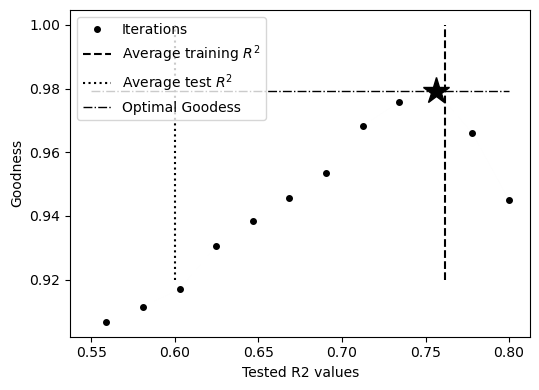

In [59]:
plt.figure(figsize=(5.5, 4))
plt.plot(tested_r_squared, goodness_metrics, marker='o', markersize=4, linewidth=0.001, color='black', label='Iterations')
plt.vlines(x=r2_train_avg, ymin=0.92, ymax=1.0, linestyle='--', color='black', label='Average training $R^2$')
plt.vlines(x=r2_test_avg, ymin=0.92, ymax=1.0, linestyle=':', color='black', label='Average test $R^2$')
plt.vlines(x=best_r_squared, ymin=0.92, ymax=0.99, linestyle='-', color='black', linewidth=0.001)
plt.hlines(y=best_goodness, xmin=0.55, xmax=0.80, linestyle='-.', color='black', linewidth=1, label='Optimal Goodess')

plt.plot(best_r_squared, goodness_metrics[max_idx], marker='*', markersize=20, color='black', linewidth=0.001)

plt.xlabel('Tested R2 values')
plt.ylabel('Goodness')
plt.legend(loc='upper left', facecolor='white')

plt.grid(False)
plt.tight_layout()
plt.show()